In [1]:
import matplotlib.pyplot as plt
import os 
import numpy as np

import tensorflow as tf
import tensorflow.contrib.layers as ly
from tensorflow.examples.tutorials.mnist import input_data

## Define leakyrelu

In [2]:
def lrelu(x,leak=0.2,name='lrelu'):
    with tf.variable_scope(name):
        f1 = 0.5*(1+leak)
        f2 = 0.5*(1-leak)
        return f1*x +f2*abs(x)

## Generator

In [17]:
def generator_conv(z):
    train = ly.fully_connected(z,4*4*512, activation_fn = tf.nn.relu,normalizer_fn=None)
    train = tf.reshape(train, (-1,512,4,4))
    train = ly.conv2d_transpose(train, 256, 3, stride=2, data_format = data_format,
                                activation_fn = tf.nn.relu ,normalizer_fn= ly.batch_norm, padding='SAME',
                                normalizer_params = {'fused':True,'data_format':data_format},
                                weights_initializer = tf.random_normal_initializer(0,0.04))# use tf.nn.fused_batch_norm
    train = ly.conv2d_transpose(train, 128, 3, stride=2, data_format = data_format,
                                activation_fn = tf.nn.relu ,normalizer_fn = ly.batch_norm, padding='SAME',
                                normalizer_params = {'fused':True,'data_format':data_format},
                                weights_initializer = tf.random_normal_initializer(0,0.04))
    train = ly.conv2d_transpose(train, 64, 3, stride=2, data_format = data_format,
                                activation_fn = tf.nn.relu ,normalizer_fn = ly.batch_norm, padding='SAME',
                                normalizer_params = {'fused':True,'data_format':data_format},
                                weights_initializer = tf.random_normal_initializer(0,0.04))
    train = ly.conv2d_transpose(train, channel, 3, stride=1, data_format = data_format,
                                activation_fn = tf.nn.tanh ,padding='SAME',
                                weights_initializer = tf.random_normal_initializer(0,0.04))
    return train

## Discriminator

In [4]:
def critic_conv(x,reuse=False):
    with tf.variable_scope('discriminator') as scope:
        if reuse:
            scope.reuse_variables()
        size = 64
        
        img = ly.conv2d(x, num_outputs = size,kernel_size=3,stride=2 ,
                       data_format = data_format, activation_fn = lrelu)
        img = ly.conv2d(img,num_outputs= 2*size,kernel_size=3 ,data_format=data_format,
                      stride=2,activation_fn=lrelu, normalizer_fn=ly.batch_norm,
                      normalizer_params={'fused':True,'data_format':data_format})
        img = ly.conv2d(img,num_outputs= 4*size,kernel_size=3 ,data_format=data_format,
                      stride=2,activation_fn=lrelu, normalizer_fn=ly.batch_norm,
                      normalizer_params={'fused':True,'data_format':data_format})
        
        img = ly.conv2d(img,num_outputs= 8*size,kernel_size=3 ,data_format=data_format,
                      stride=2,activation_fn=lrelu, normalizer_fn=ly.batch_norm,
                      normalizer_params={'fused':True,'data_format':data_format})
        img = tf.reshape(img,[batch_size,-1])
        
        disc = ly.fully_connected(img, 1,activation_fn =None)#  No activation 
    return disc

## Classifier

In [5]:
def classifier_conv(x,reuse=False):
    with tf.variable_scope('classifier') as scope:
        if reuse:
                scope.reuse_variables()
        size = 32 
        img = ly.conv2d(x,num_outputs=size ,kernel_size = 5,data_format = data_format,
                       stride = 1,activation_fn = tf.nn.relu)
        img = ly.max_pool2d(img,2, stride = 2,padding='SAME',data_format = data_format)
        img = ly.conv2d(img, num_outputs=size,kernel_size =5,data_format = data_format,
                       stride =1,activation_fn =tf.nn.relu, normalizer_fn= ly.batch_norm,
                       normalizer_params = {'fused':True,'data_format':data_format})
        img = ly.max_pool2d(img,2,stride=2,padding='SAME',data_format=data_format)
        
        img = tf.reshape(img,[batch_size,-1])
        img = ly.fully_connected(img,1024,activation_fn=tf.nn.relu)
        
        cat = ly.fully_connected(img,y_dim,activation_fn=None)
    return cat

## Build Graph and Loss function

In [6]:
def build_graph(is_test=False):
    ##################### Inputs #####################################
    # real data
    real_data = tf.placeholder(
        dtype = tf.float32, shape=(batch_size,channel,img_dim,img_dim))
    real_label = tf.placeholder(dtype = tf.float32, shape =(batch_size,y_dim))
    
    # fake data
    z_cat = tf.placeholder(dtype = tf.float32, shape=(batch_size,y_dim))
    z_rand = tf.placeholder(dtype = tf.float32, shape=(batch_size,z_dim))
    z = tf.concat([z_cat,z_rand],axis=1)
    ##################### End Inputs #################################
    
    ##################### Graph ######################################
    generator = generator_conv
    discriminator = critic_conv
    classifier = classifier_conv
    
    with tf.variable_scope('generator'):
        gen = generator(z)
        
    if is_test:
        return gen, z_cat,z_rand
    
    # image_summary
    img_sum = tf.summary.image('img',tf.transpose(gen,(0,2,3,1)),max_outputs=10)
    
    # discriminator
    disc_real = discriminator(real_data)
    disc_fake = discriminator(gen,reuse=True)
    
    # Classifier
    cat_real = classifier(real_data)
    cat_fake = classifier(gen,reuse = True)
    
    # Loss 
    # wasserstein
    d_loss = tf.reduce_mean(disc_fake-disc_real)
    g_loss = tf.reduce_mean(-disc_fake)
    g_loss_sum = tf.summary.scalar('wasserstein_loss_g',g_loss)
    c_loss_sum = tf.summary.scalar('wasserstein_loss_d',d_loss)
    
    # categorical loss
    loss_c_f = tf.nn.softmax_cross_entropy_with_logits(logits=cat_fake,labels=z_cat)
    loss_c_r = tf.nn.softmax_cross_entropy_with_logits(logits=cat_real,labels=real_label)
    loss_c_f_sum = tf.summary.scalar('categorical_c_f_loss',tf.reduce_mean(loss_c_f))
    loss_c_r_sum = tf.summary.scalar('categorical_c_r_loss',tf.reduce_mean(loss_c_r))
    loss_c = (loss_c_f+loss_c_r)/2
    loss_c_sum = tf.summary.scalar('categorical_c',tf.reduce_mean(loss_c))
    ##################### End  Graph ########################################
    
                                   
    ##################### Optimization ########################################
    # Variable Collections
    theta_g = tf.get_collection(
            tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')
    theta_d = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')
    theta_c = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='classifier')
    
    
    # Optimizers
    counter_g = tf.Variable(trainable=False, initial_value=0,dtype=tf.int32)
    opt_g = optimize(loss=g_loss, learning_rate=learning_rate_gen,
                     optimizer=tf.train.AdamOptimizer if is_adam is True else tf.train.RMSPropOptimizer,
                     variables =theta_g, global_step = counter_g, 
                     summaries = 'gradient_norm')
                                   
    counter_d = tf.Variable(trainable=False, initial_value=0,dtype=tf.int32)
    opt_d = optimize(loss=d_loss, learning_rate=learning_rate_dis,
                     optimizer=tf.train.AdamOptimizer if is_adam is True else tf.train.RMSPropOptimizer,
                     variables =theta_d, global_step = counter_g, 
                     summaries = 'gradient_norm')
                                   
    counter_c_f = tf.Variable(trainable=False, initial_value=0,dtype=tf.int32)
    opt_c_f = optimize(loss=loss_c_f, learning_rate=learning_rate_gen,
                     optimizer=tf.train.AdamOptimizer if is_adam is True else tf.train.RMSPropOptimizer,
                     variables =theta_g, global_step = counter_c_f, 
                     summaries = 'gradient_norm')
    counter_c_r = tf.Variable(trainable=False, initial_value=0,dtype=tf.int32)
    opt_c_r = optimize(loss=loss_c, learning_rate=learning_rate_cat,
                     optimizer=tf.train.AdamOptimizer if is_adam is True else tf.train.RMSPropOptimizer,
                     variables =theta_c, global_step = counter_c_r, 
                     summaries = 'gradient_norm')
    
    # Clip weights
    clipped_var_d = [tf.assign(var,tf.clip_by_value(var,clamp_lower,clamp_upper)) for var in theta_d]
    with tf.control_dependencies([opt_d]):
        opt_d = tf.tuple(clipped_var_d)
    ########################### End Optimization ################################
    return opt_g,opt_d,opt_c_f,opt_c_r,real_data,real_label, z_cat, z_rand                              

## Optimizer

In [7]:
def optimize(loss,learning_rate,optimizer,variables,global_step,summaries):
    optim = optimizer(learning_rate=learning_rate)
    
    # Calculate Gradient
    gradients = optim.compute_gradients(loss,var_list=variables)
    
    # Add summary
    if summaries is None:
        summaries = ['loss','learning_rate']
    if 'gradient_norm' in summaries:
        tf.summary.scalar('global_norm/gradient_norm',tf.global_norm(list(zip(*gradients))[0]))
    
    # Add scalar summary for loss
    if 'loss' in summaries:
        tf.summary.scalar('loss',loss)
    
    for gradient ,variable in gradients:
        if isinstance(gradient,tf.IndexedSlices):
            grad_values = gradient.values
        else:
            grad_values = gradient
        
        if grad_values is not None:
            var_name = variable.name.replace(':','_')
            if 'gradients' in summaries:
                tf.summary.histogram('gradients/%s'% var_name,grad_values)
            if 'gradient_norm' in summaries:
                tf.summary.scalar('gradient_norm/%s'%var_name,tf.global_norm([grad_values]))
                
    return optim.apply_gradients(gradients,global_step=global_step)

## Prameters

In [8]:
# Global parameters
batch_size =64
img_dim = 32
z_dim = 128
y_dim = 10
learning_rate_gen = 2e-4
learning_rate_dis = 2e-4
learning_rate_cat = 2e-4

device = '/gpu:0'
data_format = 'NCHW'
# img size
s=32
# updata Diters times for critic in one iter(unless i<25 or i % 500 ==0, i is iterstep)
c_interv = 2.0
Diters = 5
Diters = int((c_interv+1)/c_interv*Diters)

# the upper bound and lower bound of parameters in critic
clamp_lower = -0.01
clamp_upper = 0.01
# whether use adam for parameters update, if flag is set false use tf.train.RMSPropOptimizer
is_adam = False
channel = 1

# directory to store log,include loss and grad_norm of generator and critic
log_dir = './log_wgan'
ckpt_dir = './ckpt_wgan'
classifier_dir = './cat_wgan'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)
if not os.path.exists(classifier_dir):
    os.makedirs(classifier_dir)
    
# max iter step, note that  one step indicates that a Diters updatas of critic and one updatas of generator

max_iter_step = 10000

## Training step

In [9]:
def main():
    dataset = input_data.read_data_sets('MNIST_data',one_hot=True)
    with tf.device(device):
        opt_g,opt_d,opt_c_f,opt_c_r,real_data,real_label, z_cat, z_rand = build_graph()
    
    merged_all = tf.summary.merge_all()
    saver = tf.train.Saver()
    # config for session
    config = tf.ConfigProto(allow_soft_placement=True,log_device_placement=True)
    config.gpu_options.allow_growth=True
    config.gpu_options.per_process_gpu_memory_fraction=0.9
    
    def next_feed_dict(iter):
        # True data 
        train_img,train_label = dataset.train.next_batch(batch_size)
        train_img = train_img*2-1
        
        train_img = np.reshape(train_img,(-1,channel,28,28))
        npad = ((0,0),(0,0),(2,2),(2,2))
        train_img = np.pad(train_img,pad_width=npad,mode='constant',constant_values=-1)
        
        # Noise
        batch_z_rand = np.random.normal(0,1,[batch_size,z_dim]).astype(np.float32)
        # Generate random one_hot vectors as class condition
        if iter % 2 ==0:
            idx = np.random.randint(0,y_dim-1,size=(batch_size,))
        else:
            idx = np.random.randint(0,y_dim-1)
        y_generated = np.zeros((batch_size,y_dim))
        y_generated[np.arange(batch_size),idx]=1
        
        feed_dict ={real_data:train_img, real_label:train_label ,z_cat:y_generated ,z_rand:batch_z_rand}
        return feed_dict
    
    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())
        summary_writer =  tf.summary.FileWriter(log_dir,sess.graph)
        
        # training loop begain
        for i in range(max_iter_step):
            if i % 100 ==0:
                print(i)
                
            if i % 25 or i % 500==0:
                diters = 100
            else:
                diters = Diters*2
            
            # Train Discriminator
            for j in range(diters):
                feed_dict = next_feed_dict(i)
                if i % 100 ==99 and j==0:
                    run_options = tf.RunOptions(trace_level=tf.RunOptions.NO_TRACE)
                    run_metadata = tf.RunMetadata()
                    
                    _,merged =sess.run([opt_d,merged_all],feed_dict = feed_dict,options= run_options,run_metadata=run_metadata)
                    summary_writer.add_summary(merged,i)
                    summary_writer.add_run_metadata(run_metadata,'discriminator_metedata{}'.format(i),i)
                else:
                    sess.run(opt_d,feed_dict=feed_dict)
                
            # Train Generator
            feed_dict = next_feed_dict(i)
            if i% 100 == 99:
                _,merged = sess.run([opt_g,merged_all],feed_dict =feed_dict,
                                   options = run_options,run_metadata=run_metadata)
                summary_writer.add_summary(merged, i)
                summary_writer.add_run_metadata(run_metadata,'generator_metadata{}'.format(i),i)
            else:
                sess.run([opt_g],feed_dict = feed_dict)
            
            # Train Generator on Classifier
            if i % c_interv ==0:
                feed_dict = next_feed_dict(i)
                if i % 100==99:
                    _,merged = sess.run([opt_c_f, merged_all],feed_dict = feed_dict,
                                       options =run_options,run_metadata= run_metadata)
                    summary_writer.add_summary(merged_all,i)
                    summary_writer.add_run_metadata(run_metadata,'generator_f_metadata{}'.format(i),i)
                    
                else:
                    sess.run(opt_c_f,feed_dict=feed_dict)
            
            # Train Classifer on fake and real
            if i % c_interv ==0:
                feed_dict = next_feed_dict(i)
                if i %100 ==99:
                    _,merged = sess.run([opt_c_r, merged_all],feed_dict = feed_dict,
                                       options =run_options,run_metadata= run_metadata)
                    summary_writer.add_summary(merged, i)
                    summary_writer.add_run_metadata(
                        run_metadata, 'classifier_r_metadata {}'.format(i), i)
                else:
                    sess.run(opt_c_r, feed_dict=feed_dict)
            q
            # Save model
            if i %1000 == 999:
                saver.save(sess, os.path.join(ckpt_dir,'model.ckpt'),global_step=i)
         

In [10]:
def test(test_num = 10):
    img = np.zeros((img_dim*test_num, img_dim*test_num))
    
    with tf.Session(config = tf.ConfigProto(allow_soft_placement=True,log_device_placement=True)) as sess:
        with tf.device(device):
            train, z_cat,z_rand = build_graph(is_test=True)
        saver = tf.train.Saver()
        
        saver.restore(sess, tf.train.latest_checkpoint(ckpt_dir))
        
        for i in range(10):
            batch_z = np.random.normal(0,1,[batch_size,z_dim]).astype(np.float32)
            y_generated = np.zeros((batch_size,y_dim))
            y_generated[:,i] = 1
            
            output = sess.run(tf.transpose(train,(0,2,3,1)),feed_dict={z_rand:batch_z,z_cat:y_generated})
            img[:,img_dim*i:img_dim*(i+1)] =  np.reshape(output[:test_num, :, :, :],(test_num * img_dim,img_dim))
        
        image = ((img/2+0.5)*255).astype(np.uint8)
        plt.imshow(image,cmap='gray')
        plt.show()

In [11]:
if __name__ == '__main__':
    main()

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
0
100
200
300
400
500
600
700
800
900


KeyboardInterrupt: 

INFO:tensorflow:Restoring parameters from ./ckpt_wgan\model.ckpt-9999


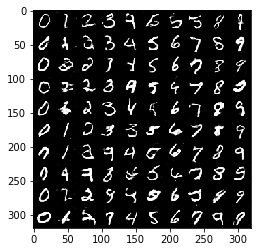

In [14]:
tf.reset_default_graph()
test()